In [1]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 47.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 8.9 MB/s eta 0:00:00


In [ ]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from langchain_core.language_models import BaseChatModel
import json
import datasets

In [ ]:
ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

langchain_docs = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=200,
    add_start_index=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

docs_processed = []
for doc in langchain_docs:
    docs_processed += text_splitter.split_documents([doc])

In [ ]:
from langchain_community.llms import HuggingFaceHub
from langchain_community.chat_models import ChatHuggingFace
from langchain.prompts import ChatPromptTemplate

repo_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"

llm = HuggingFaceHub(
    repo_id=repo_id,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

chat_model = ChatHuggingFace(llm=llm)


QA_generation_prompt = """
Your task is to write a factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Your factoid question should be formulated in the same style as questions users could ask in a search engine.
This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

Now here is the context.

Context: {context}\n
Output:::"""

QA_generation_prompt = ChatPromptTemplate.from_template(QA_generation_prompt)
QA_generation_agent = QA_generation_prompt | chat_model

In [ ]:
import random

N_GENERATIONS = (
    10  # We intentionally generate only 10 QA couples here for cost and time considerations
)

print(f"Generating {N_GENERATIONS} QA couples...")
outputs = []
for context in tqdm(random.sample(langchain_docs, N_GENERATIONS)):
    # Generate QA couple
    output_QA_couple = QA_generation_agent.invoke({"context": context.page_content}).content
    try:
        question = output_QA_couple.split("Factoid question: ")[1].split("Answer: ")[0]
        answer = output_QA_couple.split("Answer: ")[1]
        outputs.append(
            {
                "context": context.page_content,
                "question": question,
                "answer": answer,
                "source_doc": context.metadata["source"],
            }
        )
    except:
        continue

In [ ]:
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating)
Total rating: (your rating)

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating)
Total rating: (your rating)

Now here is the question.

Question: {question}\n
Answer::: """

question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independant this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question only makes sense in a specific context, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating)
Total rating: (your rating)

Now here is the question.

Question: {question}\n
Answer::: """

question_groundedness_critique_prompt = ChatPromptTemplate.from_template(
    question_groundedness_critique_prompt
)
question_groundedness_critique_agent = question_groundedness_critique_prompt | chat_model

question_relevance_critique_prompt = ChatPromptTemplate.from_template(
    question_relevance_critique_prompt
)
question_relevance_critique_agent = question_relevance_critique_prompt | chat_model

question_standalone_critique_prompt = ChatPromptTemplate.from_template(
    question_standalone_critique_prompt
)
question_standalone_critique_agent = question_standalone_critique_prompt | chat_model

In [ ]:
print("Generating critique for each QA couple...")
for output in tqdm(outputs):
    # Critique the generated QA couple
    question_groundedness_evaluation = question_groundedness_critique_agent.invoke(
        {"context": output["context"], "question": output["question"]}
    ).content
    question_relevance_evaluation = question_relevance_critique_agent.invoke(
        {"question": output["question"]}
    ).content
    question_standalone_evaluation = question_standalone_critique_agent.invoke(
        {"question": output["question"]}
    ).content

    try:
        groundedness_score = int(question_groundedness_evaluation.split("Total rating: ")[1][0])
        groundedness_eval = question_groundedness_evaluation.split("Total rating: ")[0].split(
            "Evaluation: "
        )[1]
        relevance_score = int(question_relevance_evaluation.split("Total rating: ")[1][0])
        relevance_eval = question_relevance_evaluation.split("Total rating: ")[0].split(
            "Evaluation: "
        )[1]
        standalone_score = int(question_standalone_evaluation.split("Total rating: ")[1][0])
        standalone_eval = question_standalone_evaluation.split("Total rating: ")[0].split(
            "Evaluation: "
        )[1]
        output.update(
            {
                "groundedness_score": groundedness_score,
                "groundedness_eval": groundedness_eval,
                "relevance_score": relevance_score,
                "relevance_eval": relevance_eval,
                "standalone_score": standalone_score,
                "standalone_eval": standalone_eval,
            }
        )
    except:
        continue

In [ ]:
#filter bad questions

import pandas as pd

pd.set_option("display.max_colwidth", None)

generated_questions = pd.DataFrame.from_dict(outputs)

print("Evaluation dataset before filtering:")
display(
    generated_questions[
        ["question", "answer", "groundedness_score", "relevance_score", "standalone_score"]
    ]
)
generated_questions = generated_questions.loc[
    (generated_questions["groundedness_score"] >= 4)
    & (generated_questions["relevance_score"] >= 4)
    & (generated_questions["standalone_score"] >= 4)
]
print("============================================")
print("Final evaluation dataset:")
display(
    generated_questions[
        ["question", "answer", "groundedness_score", "relevance_score", "standalone_score"]
    ]
)

eval_dataset = datasets.Dataset.from_pandas(
    generated_questions, split="train", preserve_index=False
)

In [ ]:
eval_dataset = datasets.load_dataset("m-ric/huggingface_doc_qa_eval", split="train")

### **RAG**![1_Hwd1inu4xtvVeyw-itgIMQ.webp](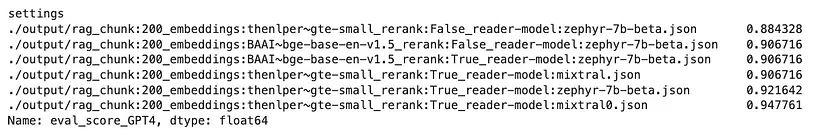![Picture1.png](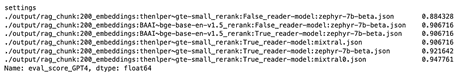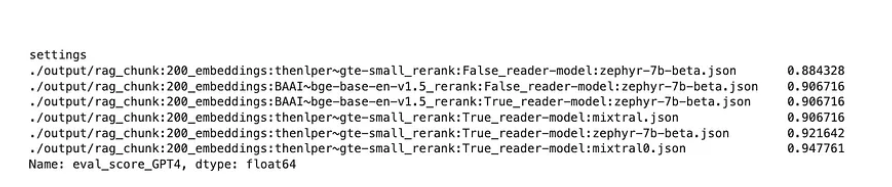))

In [ ]:
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: str,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of size `chunk_size` characters and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import os


def load_embeddings(
    langchain_docs: List[LangchainDocument],
    chunk_size: int,
    embedding_model_name: Optional[str] = "thenlper/gte-small",
) -> FAISS:
    """
    Creates a FAISS index from the given embedding model and documents. Loads the index directly if it already exists.

    Args:
        langchain_docs: list of documents
        chunk_size: size of the chunks to split the documents into
        embedding_model_name: name of the embedding model to use

    Returns:
        FAISS index
    """
    # load embedding_model
    embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        multi_process=True,
        model_kwargs={"device": "cuda"},
        encode_kwargs={"normalize_embeddings": True},  # set True to compute cosine similarity
    )

    # Check if embeddings already exist on disk
    index_name = f"index_chunk:{chunk_size}_embeddings:{embedding_model_name.replace('/', '~')}"
    index_folder_path = f"./data/indexes/{index_name}/"
    if os.path.isdir(index_folder_path):
        return FAISS.load_local(
            index_folder_path,
            embedding_model,
            distance_strategy=DistanceStrategy.COSINE,
        )

    else:
        print("Index not found, generating it...")
        docs_processed = split_documents(
            chunk_size,
            langchain_docs,
            embedding_model_name,
        )
        knowledge_index = FAISS.from_documents(
            docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
        )
        knowledge_index.save_local(index_folder_path)
        return knowledge_index

In [ ]:
from langchain_community.llms import HuggingFaceHub
from ragatouille import RAGPretrainedModel
from langchain_core.vectorstores import VectorStore
from langchain_core.language_models.llms import LLM

RAG_PROMPT_TEMPLATE = """
<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
</s>
<|assistant|>
"""

repo_id = "HuggingFaceH4/zephyr-7b-beta"
READER_MODEL_NAME = "zephyr-7b-beta"

READER_LLM = HuggingFaceHub(
    repo_id=repo_id,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

def answer_with_rag(
    question: str,
    llm: LLM,
    knowledge_index: VectorStore,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 7,
) -> Tuple[str, List[LangchainDocument]]:
    """Answer a question using RAG with the given knowledge index."""
    # Gather documents with retriever
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    answer = llm(final_prompt)

    return answer, relevant_docs

### **Evaluation - Benchmarking**

In [ ]:
def run_rag_tests(
    eval_dataset: datasets.Dataset,
    llm: BaseChatModel,
    knowledge_index: VectorStore,
    output_file: str,
    reranker: Optional[RAGPretrainedModel] = None,
    verbose: Optional[bool] = True,
    test_settings: Optional[str] = None,  # To document the test settings used
):
    """Runs RAG tests on the given dataset and saves the results to the given output file."""
    try:  # load previous generations if they exist
        with open(output_file, "r") as f:
            outputs = json.load(f)
    except:
        outputs = []

    for example in tqdm(eval_dataset):
        question = example["question"]
        if question in [output["question"] for output in outputs]:
            continue

        answer, relevant_docs = answer_with_rag(question, llm, knowledge_index, reranker=reranker)
        if verbose:
            print("=======================================================")
            print(f"Question: {question}")
            print(f"Answer: {answer}")
            print(f'True answer: {example["answer"]}')
        result = {
            "question": question,
            "true_answer": example["answer"],
            "source_doc": example["source_doc"],
            "generated_answer": answer,
            "retrieved_docs": [doc for doc in relevant_docs],
        }
        if test_settings:
            result["test_settings"] = test_settings
        outputs.append(result)

        with open(output_file, "w") as f:
            json.dump(outputs, f)

In [ ]:
EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import SystemMessage


evaluation_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="You are a fair evaluator language model."),
        HumanMessagePromptTemplate.from_template(EVALUATION_PROMPT),
    ]
)

In [ ]:
from langchain.chat_models import ChatOpenAI

eval_chat_model = ChatOpenAI(model="gpt-4-1106-preview", temperature=0)
evaluator_name = "GPT4"


def evaluate_answers(
    answer_path: str,
    eval_chat_model: BaseChatModel,
    evaluator_name: str,
    evaluation_prompt_template: ChatPromptTemplate,
) -> None:
    """Evaluates generated answers. Modifies the given answer file in place for better checkpointing."""
    answers = []
    if os.path.isfile(answer_path):  # load previous generations if they exist
        answers = json.load(open(answer_path, "r"))

    for experiment in tqdm(answers):
        if f"eval_score_{evaluator_name}" in experiment:
            continue

        eval_prompt = evaluation_prompt_template.format_messages(
            instruction=experiment["question"],
            response=experiment["generated_answer"],
            reference_answer=experiment["true_answer"],
        )
        eval_result = eval_chat_model.invoke(eval_prompt)
        feedback, score = [item.strip() for item in eval_result.content.split("[RESULT]")]
        experiment[f"eval_score_{evaluator_name}"] = score
        experiment[f"eval_feedback_{evaluator_name}"] = feedback

        with open(answer_path, "w") as f:
            json.dump(answers, f)

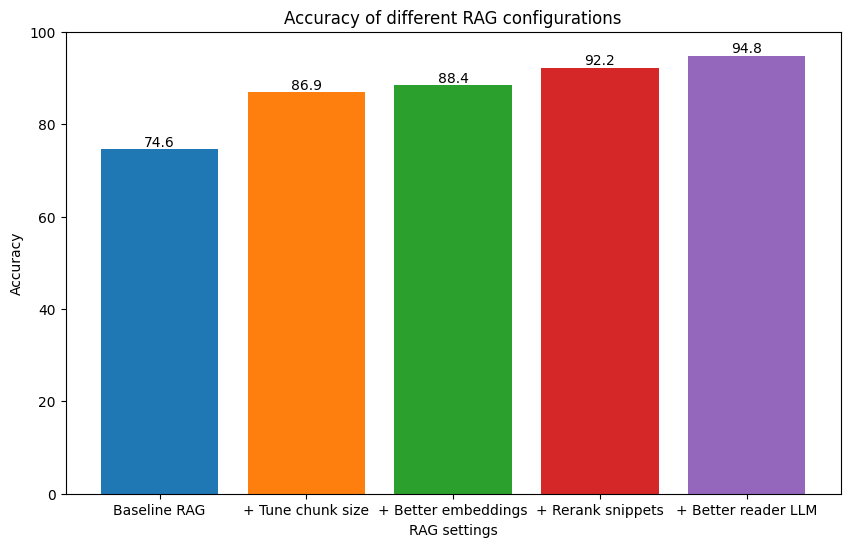

In [2]:
# Adding labels and title
plt.xlabel('RAG settings')
plt.ylabel('Accuracy')
plt.title('Accuracy of different RAG configurations')
plt.ylim(0, 100)
plt.show()
